<a href="https://colab.research.google.com/github/asarvi/RBM_BM/blob/main/RBM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch

In the first part, we load the MNIST dataset.
According to the data provided in the report, I chose the number 80 for batch size.

In [39]:
import torchvision
from torch.utils.data import DataLoader, Subset

#init batch size
batch_size = 80

#define transform
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

#load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',train=True,
                download=True,transform=transform
)

# define validation set and split dataset
validation_split = 0.1
validation_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,
                                    [train_size, validation_size])

# create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset,batch_size,shuffle=True)
test_dataset = torchvision.datasets.MNIST( root='./data',train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(test_dataset,batch_size,shuffle=False)
validation_loader = DataLoader(validation_dataset,batch_size,shuffle=False)



Here I defined some functions to use later.

In [3]:
import torch.nn as nn
#definition of sigmoid function
def sigmoid ( x ):
   sig = 1 / (1 + torch.exp(-x))
   return sig
#definition of relu function
def relu(x):
    r = torch.relu(x)
    return r

In this Cell the class RBM is defined with its necessary functions.

Training loss for epoch 0: -15.1338
Validation loss for 0 epoch: -13.8840
Training loss for epoch 1: -11.3155
Validation loss for 1 epoch: -11.0190
Training loss for epoch 2: -9.3544
Validation loss for 2 epoch: -7.7383
Training loss for epoch 3: -7.6267
Validation loss for 3 epoch: -5.6868
Training loss for epoch 4: -6.2066
Validation loss for 4 epoch: -5.6120
Training loss for epoch 5: -5.1351
Validation loss for 5 epoch: -3.5331
Training loss for epoch 6: -4.4013
Validation loss for 6 epoch: -3.4104
Training loss for epoch 7: -3.6943
Validation loss for 7 epoch: -2.3765
Training loss for epoch 8: -3.3144
Validation loss for 8 epoch: -1.5183
Training loss for epoch 9: -2.8826
Validation loss for 9 epoch: -1.9914
Training loss for epoch 10: -2.5926
Validation loss for 10 epoch: -1.6403
Training loss for epoch 11: -2.3356
Validation loss for 11 epoch: -1.7600
Training loss for epoch 12: -2.2792
Validation loss for 12 epoch: -2.1136
Training loss for epoch 13: -1.9987
Validation loss fo

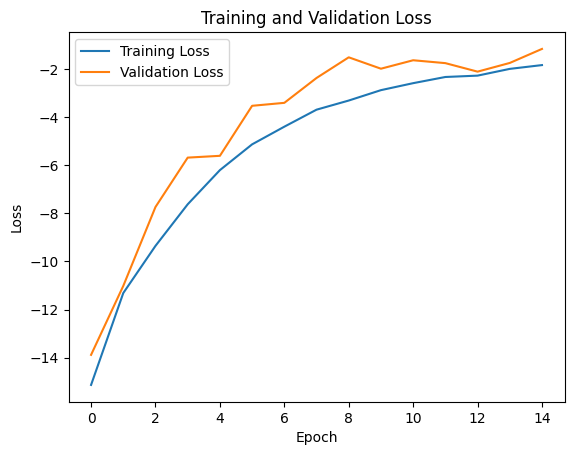

Total Training Time: 655.8213953971863 seconds


In [46]:
import torch.optim as optim
import time
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt

class RBM(nn.Module):

# init model parameters,
#number of visible units is the input size, which is 28 * 28
#I picked 400 for hidden units according to one of the methods in the report

    def __init__(self, num_vis_units =784, num_hid_units =300, num_CD = 5):
        super(RBM, self).__init__()

        xscale = math.sqrt(2.0 / (num_hid_units + num_vis_units))
        self.Weights = nn.Parameter(torch.randn(num_hid_units, num_vis_units) * xscale)
        self.v_bias = nn.Parameter(torch.zeros(num_vis_units))
        self.h_bias = nn.Parameter(torch.zeros(num_hid_units))
        self.num_CD = num_CD

    def sample_from_p(self, p):
        init_probs = torch.rand(p.size())
        probs = (p - init_probs).sign()
        final_probs = relu(probs)
        return final_probs

    def vis_to_hid(self, v):
        linear_res = torch.matmul(v, self.Weights.t()) + self.h_bias
        hid_prob = sigmoid(linear_res)
        hid_sample = self.sample_from_p(hid_prob)
        return hid_prob, hid_sample

    def hid_to_vis(self, h):
        linear_res = torch.matmul(h, self.Weights) + self.v_bias
        vis_prob = sigmoid(linear_res)
        vis_sample = self.sample_from_p(vis_prob)
        return vis_prob, vis_sample

    def forward(self, v):
        hid_prob, hid_sample = self.vis_to_hid(v)
        upd_hid = hid_sample
        for _ in range(self.num_CD):
            vis_prob, vis_sample = self.hid_to_vis(upd_hid)
            hid_prob, upd_hid = self.vis_to_hid(vis_sample)
        return v, vis_sample



    def free_energy(self, v):
        vbias = torch.mv(v, self.v_bias)
        outmul = torch.mm(v, self.Weights.t()) + self.h_bias.unsqueeze(0).expand_as(torch.mm(v, self.Weights.t()))
        hidden_term = outmul.exp().add(1).log().sum(1)
        total_free_energy = - vbias -hidden_term
        mean_free_energy = total_free_energy.mean()
        return mean_free_energy



rbm = RBM()

epochs = 15
train_losses = []
val_losses = []
train_op = optim.SGD(rbm.parameters(), lr=0.06)
time_begin = time.time()

for epoch in range(epochs):
    print("Training loss for epoch {}: ".format(epoch), end='')
    total_train_loss = 0.0
    num_train_batches = len(train_loader)

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 784)  # Reshape data if necessary
        v, v1 = rbm(data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        total_train_loss += loss.item()

        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if batch_idx == num_train_batches - 1:
            batch_train_loss = total_train_loss / num_train_batches
            print("{:.4f}".format(batch_train_loss))
            train_losses.append(batch_train_loss)

    # Compute and print validation loss
    print("Validation loss for {} epoch: ".format(epoch), end='')
    total_val_loss = 0.0
    num_val_batches = len(validation_loader)

    with torch.no_grad():
        for data, target in validation_loader:
            data = data.view(-1, 784)
            v, v1 = rbm(data)

            # Calculate loss
            loss = rbm.free_energy(v) - rbm.free_energy(v1)
            total_val_loss += loss.item()

    # Display validation loss
    batch_val_loss = total_val_loss / num_val_batches
    print("{:.4f}".format(batch_val_loss))
    val_losses.append(batch_val_loss)

# Plotting the losses
plt.plot(range(0, epochs), train_losses, label='Training Loss')
plt.plot(range(0, epochs), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

training_time = time.time() - time_begin
print("Total Training Time:", training_time, "seconds")


Training Sample: 


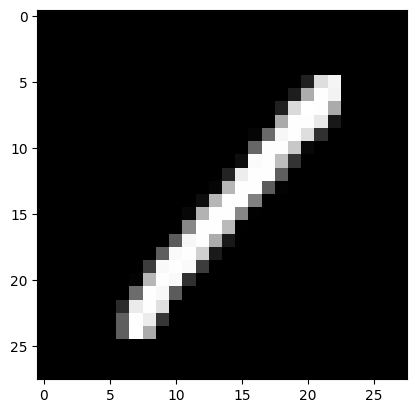

Generated Sample: 


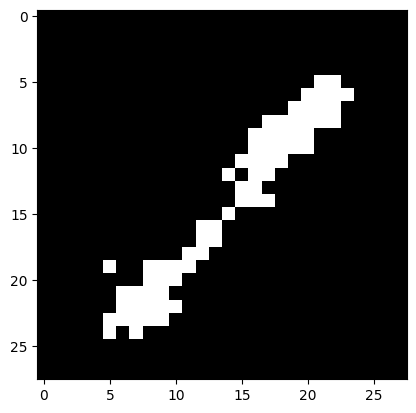

Training Sample: 


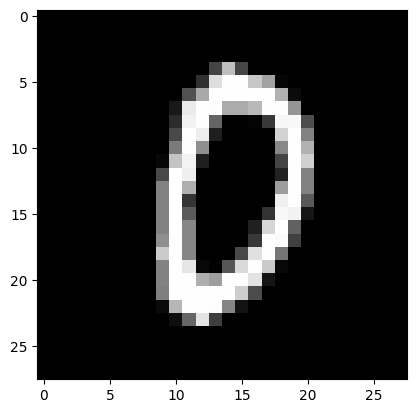

Generated Sample: 


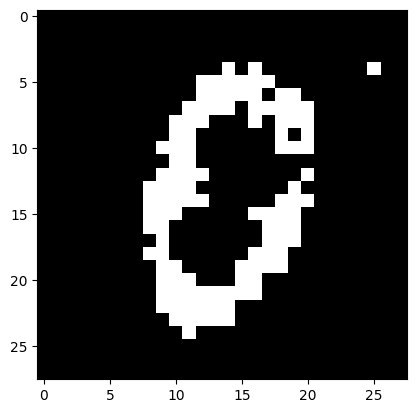

Training Sample: 


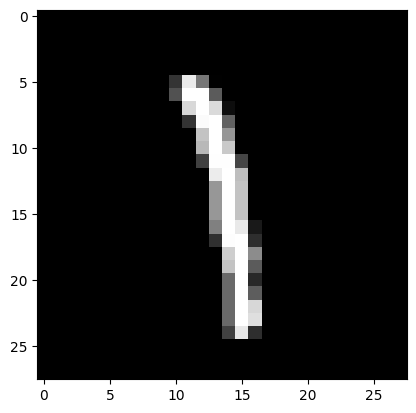

Generated Sample: 


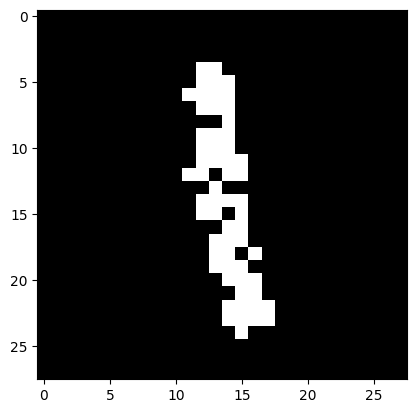

Training Sample: 


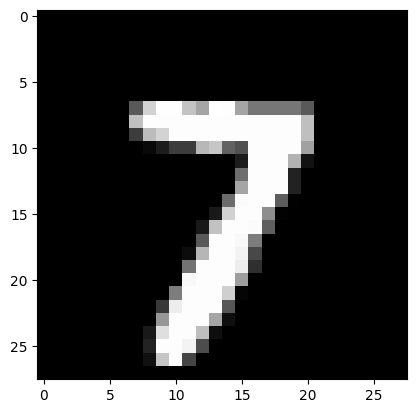

Generated Sample: 


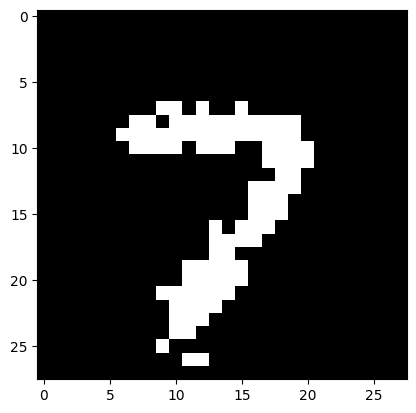

In [50]:
for i in range(4,8):
  # displaying the first digit in the batch
  print("Training Sample: ")
  sample_real = v[i].squeeze().cpu().numpy()
  sample_real = sample_real.reshape(28, 28)
  plt.imshow(sample_real, cmap='gray')
  plt.show()

  print ("Generated Sample: ")
  sample_real = v1[i].squeeze().cpu().detach().numpy()
  sample_real = sample_real.reshape(28, 28)
  plt.imshow(sample_real, cmap='gray')
  plt.show()
